>[Quantile regression from OLS to TensorFlow](#scrollTo=PQdJbWCS9N3G)

>>[Setup](#scrollTo=VjvK4vP2-X_D)

>>>[Graph options](#scrollTo=sm3RTN850S70)

>>>[Data](#scrollTo=vdaqXkSCe7gG)

>>>>[Load](#scrollTo=vdaqXkSCe7gG)

>>>>[Normalize](#scrollTo=xuphFNDqtEiW)

>>>>[Make DataFrames](#scrollTo=HDT3Cs7ptIYG)

>>>[Initialize result](#scrollTo=utzAT-gdBTqj)

>>[Quantile loss example](#scrollTo=OZ7dkNLfyZ3r)

>>[OLS](#scrollTo=6dRLoTDhCrpO)

>>[QuantReg](#scrollTo=esTAKyTyG1TS)

>>[Random forests](#scrollTo=qCt2S4V9Uepc)

>>[Gradient boosted trees](#scrollTo=6ssXXxsCA7FS)

>>[Keras](#scrollTo=H55y_74W97jH)

>>>[Quantiles 0.1, 0.5, 0.9](#scrollTo=SeMIPNsO-qxI)

>>[TensorFlow](#scrollTo=PEy2M6X89tbD)

>>[Visualize quantiles](#scrollTo=NG7Oqjp-7htm)

>>[Compare quantile loss](#scrollTo=42LIBXl933YI)

>>[All features](#scrollTo=ig_Wywm05sjA)

>>>[OLS](#scrollTo=ImnTiUft-Yhq)

>>>[Quantreg](#scrollTo=sC29BePy_dtj)

>>>[Random forests](#scrollTo=Z3g3cXQVDvBJ)

>>>[Gradient boosting](#scrollTo=kfHp4qvBDeA3)

>>>[Keras](#scrollTo=tLm8TjoV_qap)

>>>[TensorFlow](#scrollTo=G_lApuMnAoR9)

>>>[Compare](#scrollTo=hn3sxw4yDXdz)



# Quantile regression from OLS to TensorFlow

Use the Boston housing dataset.

Based on blog posts using:
* Keras: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
* Tensorflow: https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* statsmodels quantile regression: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

## Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import norm

from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras

Keras and TensorFlow options

In [2]:
EPOCHS = 200
BATCH_SIZE = 32
UNITS = 512

### Graph options

In [3]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [4]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Data

#### Load

In [5]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = \
    boston_housing.load_data()

In [6]:
train_data.shape

(404, 13)

In [7]:
test_data.shape

(102, 13)

#### Make DataFrames

In [8]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

train_df = pd.DataFrame(train_data, columns=column_names)
test_df = pd.DataFrame(test_data, columns=column_names)

#### Normalize

In [9]:
train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


In [10]:
mean = train_df.mean(axis=0)
std = train_df.std(axis=0)
train_df = (train_df - mean) / std
test_df = (test_df - mean) / std

In [11]:
x_train = train_df.AGE
x_test = test_df.AGE

Denormalize.

In [12]:
def denorm_AGE(x):
    return x * std.AGE + mean.AGE

x_train_denorm = denorm_AGE(x_train)
x_test_denorm = denorm_AGE(x_test)

Reformat data for `statsmodels`.

In [13]:
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

Reformat data for `tensorflow`.

In [14]:
x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

### Initialize result

Dataset per method, quantile, and `x` value.

In [15]:
METHODS = ['OLS', 'QuantReg', 'Random forests', 'Gradient boosting', 'Keras',
           'TensorFlow']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [16]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]

In [17]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [18]:
preds['label'] = np.resize(test_labels, preds.shape[0])

## Quantile loss example

In [19]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [20]:
quantile_loss_example_e = np.linspace(-1, 1, 1000)
quantile_loss_example_loss_10 = quantile_loss(0.1, 0, quantile_loss_example_e)
quantile_loss_example_loss_50 = quantile_loss(0.5, 0, quantile_loss_example_e)
quantile_loss_example_loss_90 = quantile_loss(0.9, 0, quantile_loss_example_e)

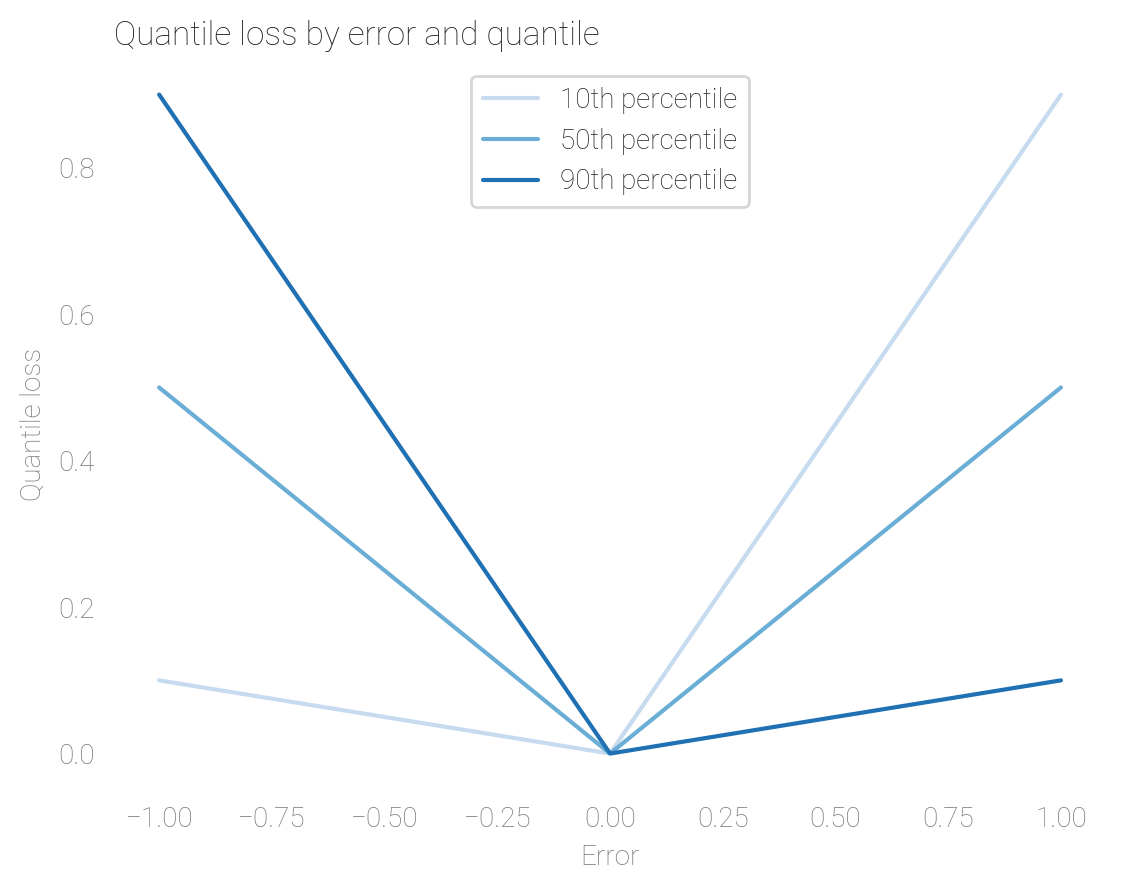

In [21]:
with sns.color_palette('Blues', 3):
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_10)
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_50)
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_90)
    plt.legend([str(int(q * 100)) + 'th percentile' for q in [0.1, 0.5, 0.9]])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Error')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by error and quantile', loc='left');

In [22]:
quantile_loss_example_q = np.linspace(0.01, 0.99, 99)
quantile_loss_example_loss_neg1 = quantile_loss(quantile_loss_example_q, 0, -1)
quantile_loss_example_loss_pos1 = quantile_loss(quantile_loss_example_q, 0, 1)

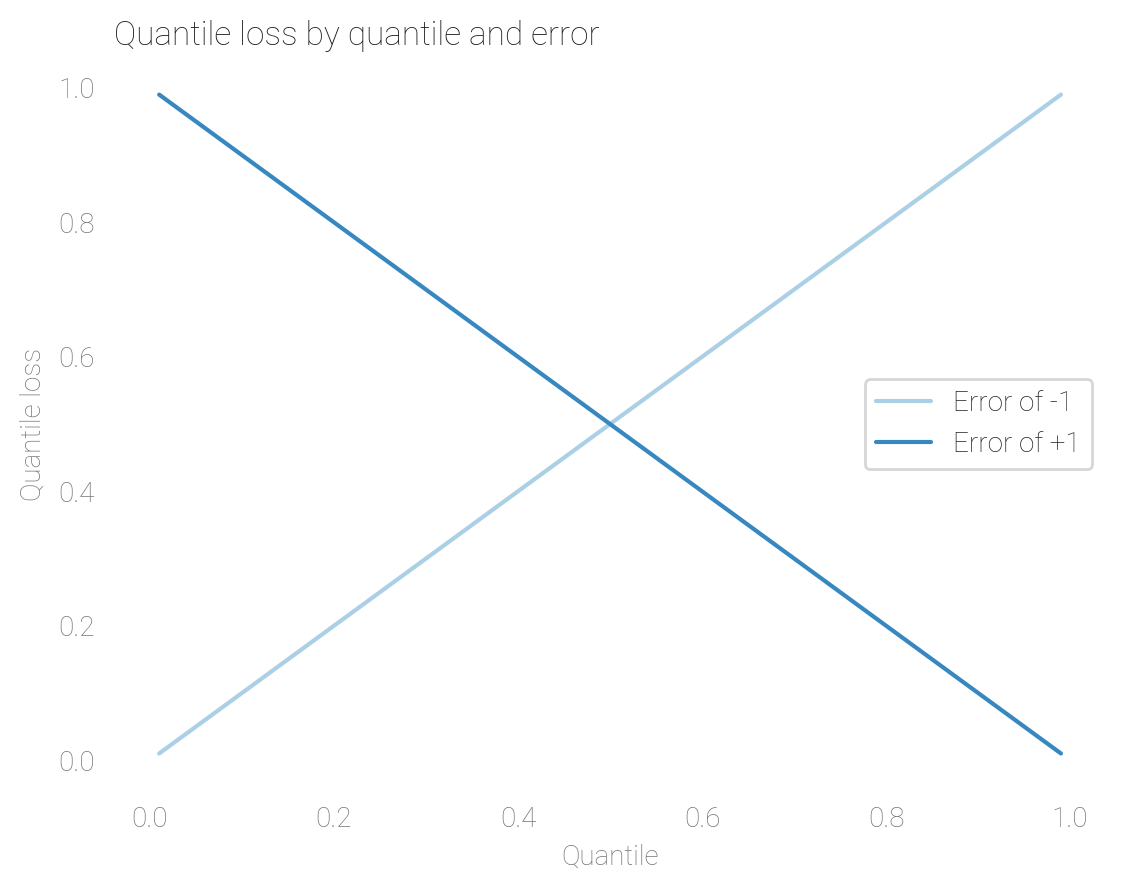

In [23]:
with sns.color_palette('Blues', 2):
    plt.plot(quantile_loss_example_q, quantile_loss_example_loss_neg1)
    plt.plot(quantile_loss_example_q, quantile_loss_example_loss_pos1)
    plt.legend(['Error of -1', 'Error of +1'])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by quantile and error', loc='left');

### Scatter plot of AGE

In [24]:
mean.AGE

69.01064356435643

In [25]:
std.AGE

27.940664897596555

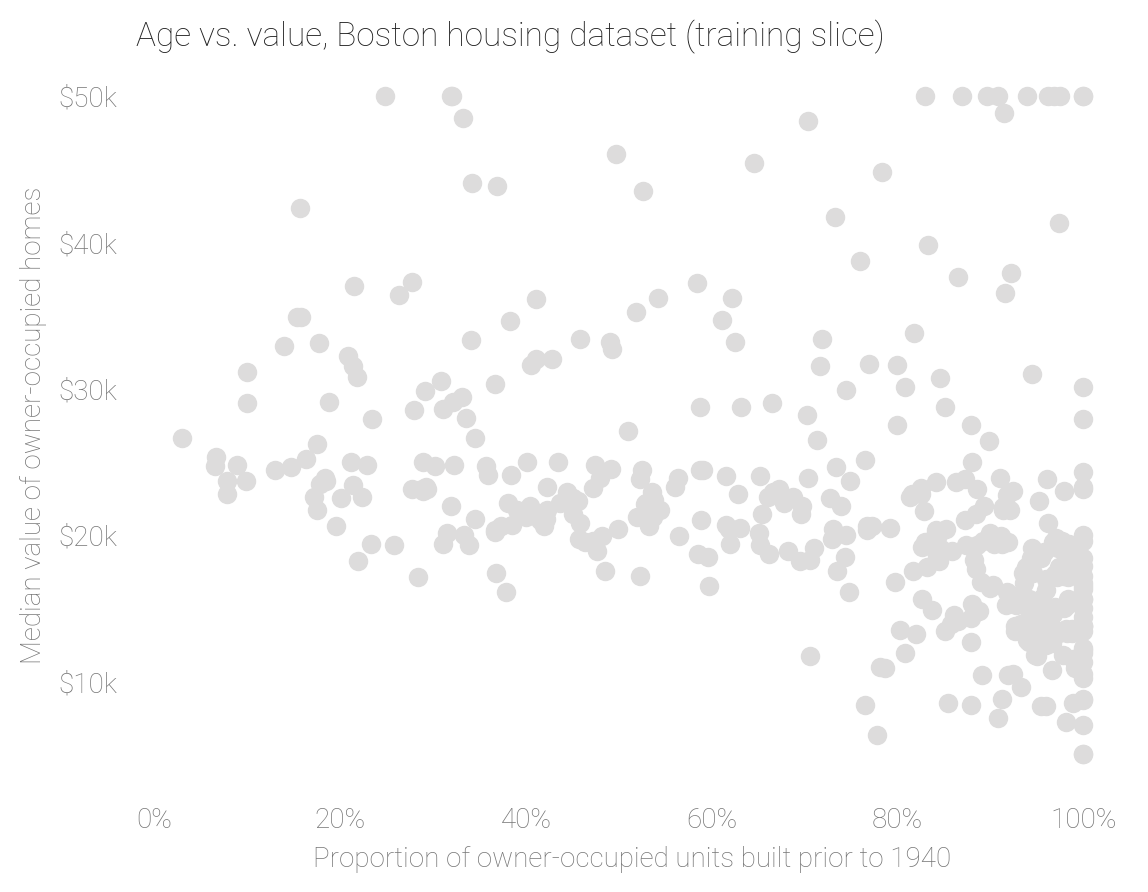

In [26]:
from matplotlib.ticker import FuncFormatter

ax = plt.scatter(x_train_denorm, train_labels, color=dot_color)
plt.title('Age vs. value, Boston housing dataset (training slice)', loc='left')
sns.despine(left=True, bottom=True)
ax.axes.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: '{:.0%}'.format(x / 100)))
ax.axes.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: '${:.0f}k'.format(y)))
plt.xlabel('Proportion of owner-occupied units built prior to 1940')
plt.ylabel('Median value of owner-occupied homes')
plt.show()

## OLS

https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

In [27]:
ols = sm.OLS(train_labels, X_train).fit()

In [28]:
def ols_quantile(m, X, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    #
    # Set alpha based on q. Vectorized for different values of q.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + norm.ppf(q) * se

In [29]:
preds.loc[preds.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES]) 

## QuantReg

https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

In [30]:
quantreg = sm.QuantReg(train_labels, X_train)  # Don't fit yet, since we'll fit once per quantile.

In [31]:
preds.loc[preds.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

## Random forests

In [32]:
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(X_train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=3, verbose=True, warm_start=False)

In [33]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [34]:
preds.loc[preds.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

## Gradient boosted trees

In [35]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [36]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 

## Keras

From https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

One area that Deep Learning has not explored extensively is the uncertainty in estimates. However, as far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. eg. For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. The uncertainty of the estimate of an individuals weight is less interesting.

### Quantiles 0.1, 0.5, 0.9

The loss for an individual data point is defined as:
$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$
where $\alpha$ is the required quantile and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model. The final overall loss is defines as:
$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

The following function defines the loss function for a quantile model.

**Note**: The following 4 lines is ALL that you change in comparison to a normal Deep Learning method, i.e. The loss function is all that changes.

In [37]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [39]:
# optimizer = tf.train.AdamOptimizer(0.001)
optimizer = tf.optimizers.Adam(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [40]:
def keras_pred(x_train, train_labels, x_test, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

In [41]:
preds.loc[preds.method == 'Keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

0.1
0.3
0.5
0.7
0.9


## TensorFlow

Adapted from https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb

In [51]:
# # Initialize session
# # sess = tf.Session()
# sess = tf.compat.v1.Session()

In [52]:
# # Create network
# class q_model:
#     def __init__(self, 
#                  sess, 
#                  quantiles,
#                  in_shape=1, 
#                  out_shape=1, 
#                  batch_size=32):
        
#         self.sess = sess
        
#         self.quantiles = quantiles
#         self.num_quantiles = len(quantiles)
        
#         self.in_shape = in_shape
#         self.out_shape = out_shape
#         self.batch_size = batch_size
        
#         self.outputs = []
#         self.losses = []
#         self.loss_history = []
        
#         self.build_model()
        
#     def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
#         with tf.variable_scope(scope, reuse=reuse) as scope:
#             self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
#             self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

#             self.layer0 = tf.layers.dense(self.x, 
#                                           units=UNITS, 
#                                           activation=tf.nn.relu)
#             self.layer1 = tf.layers.dense(self.layer0, 
#                                           units=UNITS,
#                                           activation=tf.nn.relu)

#             # Create outputs and losses for all quantiles
#             for i, q in enumerate(self.quantiles):
#                 # Get output layers 
#                 output = tf.layers.dense(self.layer1, self.out_shape,
#                                          name="{}_q{}".format(i, int(q * 100)))
#                 self.outputs.append(output)
                
#                 # Create losses
#                 error = tf.subtract(self.y, output)
#                 loss = tf.reduce_mean(tf.maximum(q * error, (q - 1) * error),
#                                       axis=-1)

#                 self.losses.append(loss)

#             # Create combined loss
#             self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
#             self.train_step = tf.train.AdamOptimizer().minimize(
#                 self.combined_loss)

#     def fit(self, x, y, epochs=EPOCHS):
#         for epoch in range(epochs):
#             epoch_losses = []
#             for idx in range(0, x.shape[0], self.batch_size):
#                 batch_x = x[idx : min(idx + self.batch_size, x.shape[0]), :]
#                 batch_y = y[idx : min(idx + self.batch_size, y.shape[0]), :]

#                 feed_dict = {self.x: batch_x,
#                              self.y: batch_y}

#                 _, c_loss = self.sess.run([self.train_step, self.combined_loss],
#                                           feed_dict)
#                 epoch_losses.append(c_loss)
                
#             epoch_loss =  np.mean(epoch_losses)
#             self.loss_history.append(epoch_loss)
#             if epoch % 100 == 0:
#                 print("Epoch {}: {}".format(epoch, epoch_loss))
            
#     def predict(self, x):   
#         # Run model to get outputs
#         feed_dict = {self.x: x}
#         predictions = sess.run(self.outputs, feed_dict)
        
#         return predictions

In [54]:
# # Instantiate model
# tf_model = q_model(sess, QUANTILES, in_shape=1, out_shape=1,
#                    batch_size=BATCH_SIZE)

# # Initialize all variables
# init_op = tf.global_variables_initializer()
# sess.run(init_op)

In [ ]:
# # Run training
# tf_model.fit(x_train_expanded, train_labels_expanded, EPOCHS)

Epoch 0: 54.29452133178711
Epoch 100: 10.774564743041992


In [ ]:
# preds.loc[preds.method == 'TensorFlow', 'pred'] = \
#     np.array([item for sublist in tf_model.predict(x_test_expanded)
#               for item in sublist])

Denormalize `x`

In [ ]:
# preds['x_denorm'] = denorm_AGE(preds.x)

## Visualize quantiles

In [56]:
# for i, method in enumerate(METHODS):
#     ax = plt.scatter(x_test_denorm, test_labels, color=dot_color)
#     plt.plot(preds[preds.method == method].pivot_table(
#         index='x_denorm', columns='q', values='pred'))
#     plt.legend(quantiles_legend)
#     # Reversing legend isn't working, possibly because of multiple plots.
# #     handles, labels = ax.get_legend_handles_labels()
# #     ax.legend(handles[::-1], labels[::-1])
#     plt.xlim((0, 100))
#     ax.axes.xaxis.set_major_formatter(FuncFormatter(
#         lambda x, _: '{:.0%}'.format(x / 100)))
#     ax.axes.yaxis.set_major_formatter(FuncFormatter(
#         lambda y, _: '${:.0f}k'.format(y)))
#     plt.xlabel('Proportion of owner-occupied units built prior to 1940')
#     plt.ylabel('Median value of owner-occupied homes')
#     plt.title(method + ' quantiles', loc='left')
#     sns.despine(left=True, bottom=True)
#     plt.show()

## Compare quantile loss

In [57]:
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

In [58]:
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
  
    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette('Blues'):
        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile loss per quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))

                   quantile_loss
method                          
Keras                   2.204128
QuantReg                2.274849
OLS                     2.281734
Gradient boosting       2.433149
Random forests          3.191606
method     Keras  QuantReg       OLS  Gradient boosting  Random forests
q                                                                      
0.1     1.094950  1.150024  1.218665           1.116370        1.717716
0.3     2.261291  2.411370  2.402398           2.352626        2.865775
0.5     2.880446  2.990252  2.970241           2.925456        4.095943
0.7     2.921171  2.981039  2.963606           3.203561        3.939574
0.9     1.862783  1.841559  1.853761           2.567730        3.339022


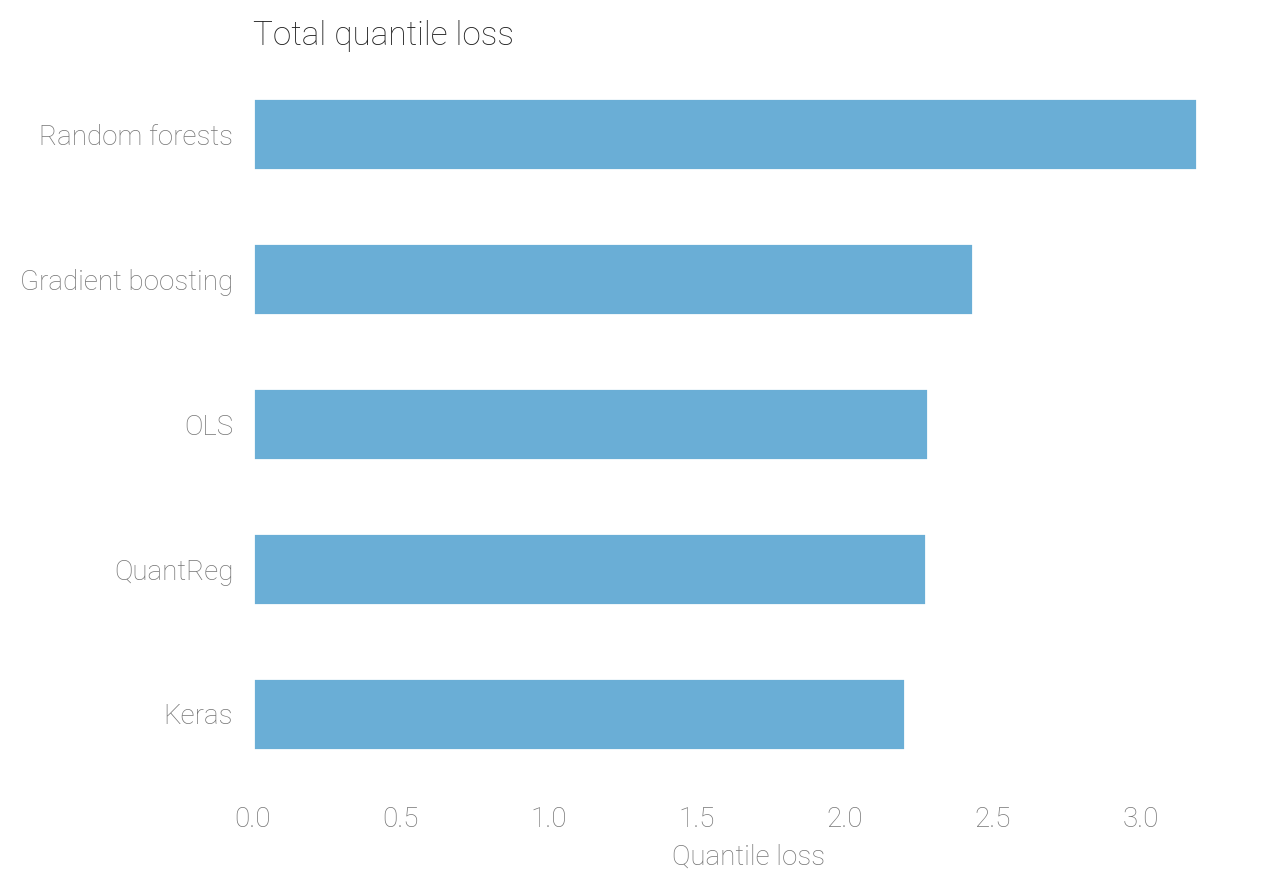

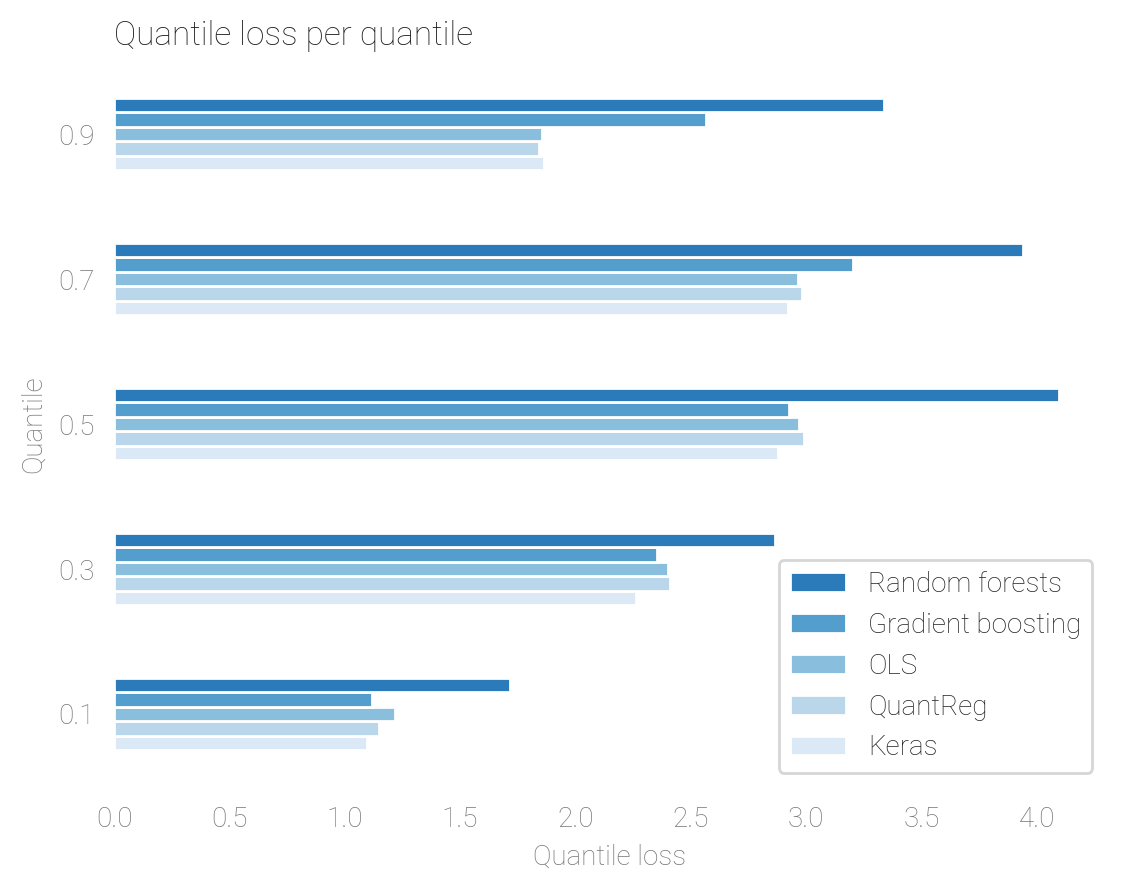

In [59]:
plot_loss_comparison(preds)

## All features

Same analysis but using all `x` features.

In [60]:
preds_full = preds[['method', 'q', 'label']].copy(deep=True)

In [61]:
x_train_full = train_df.copy(deep=True)
x_test_full = test_df.copy(deep=True)

Reformat data for `statsmodels`.

In [62]:
X_train_full = sm.add_constant(x_train_full)
X_test_full = sm.add_constant(x_test_full)

### OLS

In [63]:
ols_full = sm.OLS(train_labels, X_train_full).fit()

In [64]:
preds_full.loc[preds_full.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols_full, X_test_full, q) for q in QUANTILES]) 

### Quantreg

In [65]:
# Don't fit yet, since we'll fit once per quantile.
quantreg_full = sm.QuantReg(train_labels, X_train_full)

In [66]:
preds_full.loc[preds_full.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg_full.fit(q=q).predict(X_test_full) for q in QUANTILES])

### Random forests

In [67]:
rf_full = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                         min_samples_leaf=1, random_state=3, 
                                         n_jobs=-1)
rf_full.fit(X_train_full, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=3, verbose=0, warm_start=False)

In [68]:
preds_full.loc[preds_full.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf_full, X_test_full, q) for q in QUANTILES]) 

### Gradient boosting

In [69]:
preds_full.loc[preds_full.method == 'Gradient boosting', 'pred'] = \
    np.concatenate([gb_quantile(X_train_full, train_labels, X_test_full, q) 
                    for q in QUANTILES]) 

### Keras

In [70]:
preds_full.loc[preds_full.method == 'Keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_full, train_labels, x_test_full, q) for q in QUANTILES]) 

0.1
0.3
0.5
0.7
0.9


### TensorFlow

Reset graph to avoid conflicts with previous model.

In [71]:
# tf.reset_default_graph()
# sess = tf.Session()

In [ ]:
# # Instantiate model
# tf_model_full = q_model(sess, QUANTILES, in_shape=train_data.shape[1],
#                         batch_size=BATCH_SIZE)

# # Initialize all variables
# init_op = tf.global_variables_initializer()
# sess.run(init_op)

# # Run training
# tf_model_full.fit(train_data, train_labels_expanded, EPOCHS)

# preds_full.loc[preds_full.method == 'TensorFlow', 'pred'] = np.array(
#     [item for sublist in tf_model_full.predict(test_data)
#      for item in sublist]
# )

Epoch 0: 28.826343536376953
Epoch 100: 4.595376968383789


### Compare

In [72]:
preds_full['quantile_loss'] = quantile_loss(preds_full.q, preds_full.label, 
                                            preds_full.pred)

                   quantile_loss
method                          
Gradient boosting       0.935101
Random forests          0.949967
QuantReg                1.226544
Keras                   1.230829
OLS                     1.336441
method  Gradient boosting  Random forests  QuantReg     Keras       OLS
q                                                                      
0.1              0.677831        0.696490  0.638376  0.704750  0.809629
0.3              1.023530        1.092618  1.298750  1.551443  1.453858
0.5              1.121725        1.196814  1.544485  1.459134  1.732093
0.7              1.114777        1.107627  1.518282  1.478704  1.702171
0.9              0.737646        0.656284  1.132828  0.960111  0.984452


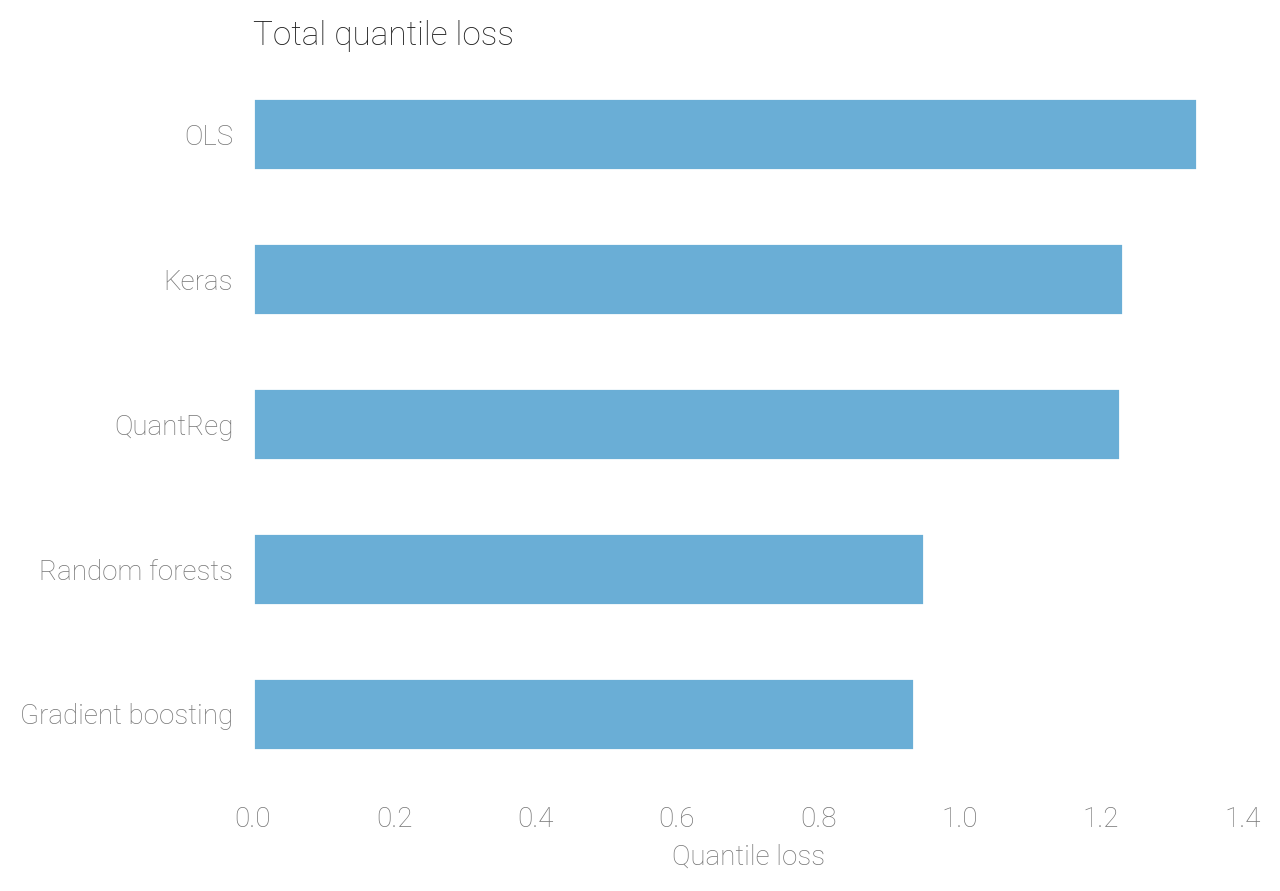

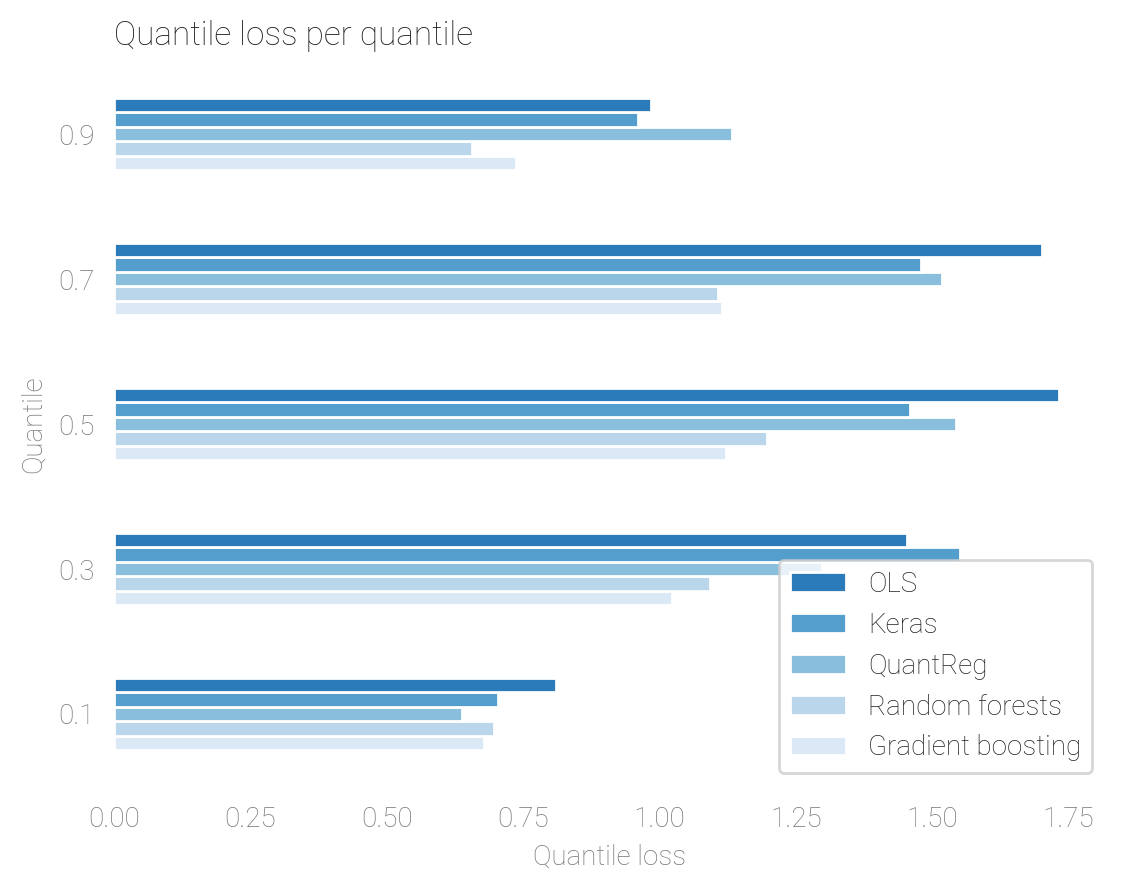

In [73]:
plot_loss_comparison(preds_full)

Save everything manually using `pickle` (`shelve` and `dill` fail for some objects ([issue](https://github.com/uqfoundation/dill/issues/155))).

In [ ]:
# import pickle

# !mkdir quantile_regression_comparison

# for i in ['preds']:
#     pickle.dump(eval(i),
#                 open('quantile_regression_comparison/' + i + '.p', 'wb'))